In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pathlib
import os
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date

# Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/UOC/TFM/

Mounted at /content/drive
/content/drive/MyDrive/UOC/TFM


## Datos sobre los viajes

In [ ]:
def count_trips(df, direction):
  
  if direction not in ('inbound','outbound'):
    raise Exception('Invalid value for direction')
  else:
    trip_time = 'started_at' if direction == 'outbound' else 'ended_at'
    trip_station = 'start_station_id' if direction == 'outbound' else 'end_station_id'
    df_filtered = df[[trip_time, trip_station, 'duration']]
    df_filtered[trip_time] = pd.to_datetime(df_filtered[trip_time])
    df_filtered['day'] = df_filtered[trip_time].dt.date
    df_filtered['hour'] = df_filtered[trip_time].dt.hour
    df_filtered = df_filtered[['day', 'hour', trip_station, 'duration']]
    df_filtered['trips'] = 1
    df_grouped=df_filtered.groupby(['day', 'hour', trip_station], as_index=False).agg({'duration':'mean','trips':'sum'})
    
    return df_grouped

## Datos sobre las estaciones

In [ ]:
def stations_data(df):

  column_names = ['id', 'name', 'latitude', 'longitude']
  df_filtered_outbound = df[['start_station_id','start_station_name','start_station_latitude', 'start_station_longitude']]
  df_filtered_inbound = df[['end_station_id','end_station_name','end_station_latitude', 'end_station_longitude']]
  df_filtered_outbound.columns = column_names
  df_filtered_inbound.columns = column_names
  df_filtered = df_filtered_outbound.append(df_filtered_inbound)

  return df_filtered.drop_duplicates()

## Lectura de datos

In [ ]:
def read_monthly_data(filepath):

  df = pd.read_csv(filepath)
  df_outbounds = count_trips(df,'outbound')
  df_inbounds = count_trips(df,'inbound')
  df_stations = stations_data(df)

  return df_outbounds, df_inbounds, df_stations

In [ ]:
def read_data(dirpath):

  df_outbounds = pd.DataFrame(columns=['day', 'hour', 'start_station_id', 'duration','trips'])
  df_inbounds = pd.DataFrame(columns=['day', 'hour', 'end_station_id', 'duration','trips'])
  df_stations = pd.DataFrame(columns=['id', 'name', 'latitude', 'longitude'])

  for year in os.scandir(dirpath):
    for month in os.scandir(year):
      monthly_outbounds, monthly_inbounds, monthly_stations = read_monthly_data(month)
      df_outbounds = df_outbounds.append(monthly_outbounds)
      df_inbounds = df_inbounds.append(monthly_inbounds)
      df_stations = df_stations.append(monthly_stations)

  return df_outbounds, df_inbounds, df_stations.drop_duplicates().reset_index(drop=True)

In [ ]:
DATA_DIR = pathlib.Path('data')

outbounds, inbounds, stations = read_data(DATA_DIR) #Esto tarda 2 mins
display(outbounds.head(10))
display(stations.head(10))

,day,hour,start_station_id,duration,trips
0,2020-12-01,4,384,320.0,1
1,2020-12-01,4,444,500.0,1
2,2020-12-01,4,493,414.0,1
3,2020-12-01,4,511,828.0,1
4,2020-12-01,4,525,846.0,1
5,2020-12-01,4,540,258.0,1
6,2020-12-01,4,597,315.0,1
7,2020-12-01,4,607,442.0,1
8,2020-12-01,5,377,388.0,1
9,2020-12-01,5,383,695.5,2


,id,name,latitude,longitude
0,540,Lilleborgbanen,59.933632,10.769118
1,511,Henrik Ibsens gate,59.915088,10.722280
2,525,Myraløkka Øst,59.937205,10.760581
3,597,Fredensborg,59.920995,10.750358
4,384,Vår Frelsers gravlund sør,59.919463,10.743829
5,607,Marcus Thranes gate,59.932772,10.758595
6,444,AHO,59.925265,10.750462
7,493,Sofienbergparken nordvest,59.924364,10.761586
8,563,Huitfeldts gate,59.912684,10.722900
9,489,Torggata,59.915983,10.751551


# Análisis descriptivo

- Análisis por:
  - hora y día
  - mes
  - día
  - hora
  - dia de la semana
  - época del año

- Análisis de estaciones con más diferencia entre outbound e inbound por hora

- Añadir el clima y comparar con la duración de los viajes

- Mostrar en un mapa inbounds y outbounds de estaciones (opc)



In [ ]:
trips_by_day_hour = outbounds.groupby(['day', 'hour'], as_index=False).agg({'trips':'sum'})
trips_by_day_hour['day_hour'] = pd.to_datetime(trips_by_day_hour['day']) + pd.to_timedelta(trips_by_day_hour['hour'], unit='h')
trips_by_day_hour.head()

,day,hour,trips,day_hour
0,2020-03-17,23,3,2020-03-17 23:00:00
1,2020-03-18,5,21,2020-03-18 05:00:00
2,2020-03-18,6,56,2020-03-18 06:00:00
3,2020-03-18,7,63,2020-03-18 07:00:00
4,2020-03-18,8,45,2020-03-18 08:00:00


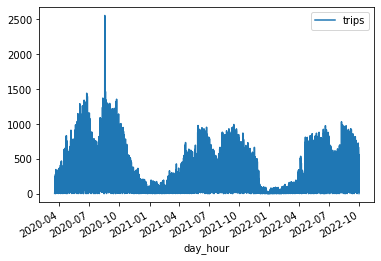

In [ ]:
trips_by_day_hour.plot(x='day_hour', y='trips')
plt.show()